In [22]:
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict
from langchain_core.prompts import ChatPromptTemplate
import PyPDF2
import os
from dotenv import load_dotenv
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart

In [23]:
load_dotenv()

True

In [24]:
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
EMAIL_SENDER = os.getenv("EMAIL_SENDER")
EMAIL_PASSWORD = os.getenv("EMAIL_PASSWORD")  
SMTP_SERVER = os.getenv("SMTP_SERVER", "smtp.gmail.com")
SMTP_PORT = int(os.getenv("SMTP_PORT", 587))

In [25]:
llm = ChatGroq(
    model="llama-3.3-70b-versatile",
    temperature=0.3,
    max_retries=2,
)

In [26]:
llm.invoke("What is the capital of France?")

AIMessage(content='The capital of France is Paris.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 42, 'total_tokens': 50, 'completion_time': 0.007409188, 'prompt_time': 0.008640977, 'queue_time': 0.058116226, 'total_time': 0.016050165}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_9a8b91ba77', 'finish_reason': 'stop', 'logprobs': None}, id='run-4bed083f-c9f0-4f70-97fd-b221751ad577-0', usage_metadata={'input_tokens': 42, 'output_tokens': 8, 'total_tokens': 50})

In [27]:
JOB_DESCRIPTION = """
Python Developer Position
Requirements:
- 5+ years of professional Python development experience
- Strong proficiency in Python 3.x, Django/Flask, and SQL databases
- Experience with RESTful APIs and microservices architecture
- Familiarity with cloud platforms (AWS/GCP/Azure)
- Strong problem-solving skills and unit testing experience
- Excellent communication skills
Preferred:
- Experience with Docker and Kubernetes
- Knowledge of CI/CD pipelines
- Bachelor's degree in Computer Science or related field
"""

In [28]:
# Define GraphState
class GraphState(TypedDict):
    application: str
    job_description: str
    candidate_email: str
    experience_level: str
    skill_match: str
    response: str
    extracted_resume: str

In [29]:
def extract_resume_text(pdf_file_path: str) -> str:
    """Extract text from a PDF resume."""
    try:
        with open(pdf_file_path, 'rb') as file:
            pdf_reader = PyPDF2.PdfReader(file)
            text = ""
            for page in pdf_reader.pages:
                text += page.extract_text() + "\n"
            return text.strip()
    except Exception as e:
        return f"Error reading PDF: {str(e)}"

In [30]:
def send_email(to_email: str, subject: str, body: str) -> bool:
    """Send an email to the candidate with the screening response."""
    try:
        msg = MIMEMultipart()
        msg['From'] = EMAIL_SENDER
        msg['To'] = to_email
        msg['Subject'] = subject
        msg.attach(MIMEText(body, 'plain'))

        with smtplib.SMTP(SMTP_SERVER, SMTP_PORT) as server:
            server.starttls()
            server.login(EMAIL_SENDER, EMAIL_PASSWORD)
            server.send_message(msg)
        print(f"Email sent to {to_email}")
        return True
    except Exception as e:
        print(f"Error sending email: {str(e)}")
        return False

In [31]:
def categorize_experience(state: GraphState) -> GraphState:
    """Categorize candidate's experience level based on resume and job description."""

    print("\nCategorizing experience level of candidate")
    prompt = ChatPromptTemplate.from_template(
        """Given the job description and candidate's resume, determine the candidate's experience level.
        Job Description: {job_description}
        Resume: {application}
        
        Analyze years of experience, roles, and responsibilities to categorize as:
        - Entry Level 
        - Mid Level 
        - Senior Level 
        
        Just output only the categorization. Do not include any other text."""
    )

    chain = prompt | llm
    experience_level = chain.invoke({
        "job_description": state["job_description"],
        "application": state["extracted_resume"]
    }).content.strip().split('\n')[-1]
    
    return {"experience_level": experience_level}

In [32]:
def assess_skills(state: GraphState) -> GraphState:
    """Assess candidate's skills against job requirements."""
    print("\nAssessing candidate skills")

    prompt = ChatPromptTemplate.from_template(
        """Compare the candidate's resume with the job description and assess skill compatibility.
        Job Description: {job_description}
        Resume: {application}
        
        Evaluate based on:
        - Required technical skills (Experience, frameworks, databases, etc.)
        - Preferred skills
        - Relevant project experience
        - Education qualifications
        
        Provide a brief explanation and return 'Match' if the candidate meets more than 75percent of requirements,
        'Partial Match' if 40-75 percent of requirements are met, or 'No Match' if below 40 percent.

        Return only the match level (Match, Partial Match, or No Match)."""
    )
    
    chain = prompt | llm
    skill_match = chain.invoke({
        "job_description": state["job_description"],
        "application": state["extracted_resume"]
    }).content.strip().split('\n')[-1]
    return {"skill_match": skill_match}

In [33]:
def schedule_interview(state: GraphState) -> GraphState:
    """Schedule an interview and notify candidate via email."""

    print("\nScheduling interview with candidate")
    response = "Candidate has been shortlisted for an interview. Recommended for technical interview round."
    email_body = f"""Dear Candidate,

    Thank you for applying for the Python Developer position. Based on our review of your resume, we are pleased to invite you for a technical interview.

    Next Steps:
    - Our HR team will contact you within 2-3 business days to schedule the interview.
    - Please prepare to discuss your experience with Python, Django/Flask, and cloud platforms.

    Best regards,
    Hiring Team
    """
    
    send_email(state["candidate_email"], "Interview Invitation - Python Developer Position", email_body)
    return {'response': response}


In [34]:
def escalate_to_recruiter(state: GraphState) -> GraphState:
    """Escalate to a recruiter for senior candidates and notify candidate."""

    print("\nEscalating to a recruiter")
    response = "Candidate has been escalated to a recruiter for further review."
    email_body = f"""Dear Candidate,

    Thank you for applying for the Python Developer position. Your application has been escalated to our senior recruitment team for further review due to your matching skills and experience.

    Next Steps:
    - A senior recruiter will reach out within 3-5 business days to discuss potential opportunities.
    - Please feel free to contact us if you have any questions.

    Best regards,
    Hiring Team
    """
    send_email(state["candidate_email"], "Application Update - Python Developer Position", email_body)
    return {'response': response}

In [35]:
def reject_application(state: GraphState) -> GraphState:
    """Reject the application and notify candidate."""

    print("\nRejecting application")
    response = "Candidate does not meet the minimum requirements for the position."
    email_body = f"""Dear Candidate,

    Thank you for applying for the Python Developer position. After careful consideration, we have determined that your qualifications do not fully meet the requirements for this role.

    We appreciate your interest and encourage you to apply for other positions that align with your skills and experience.

    Best regards,
    Hiring Team
    """
    
    send_email(state["candidate_email"], "Application Update - Python Developer Position", email_body)
    return {'response': response}


In [36]:
# Initialize workflow
workflow = StateGraph(GraphState)

In [37]:
# Add nodes
workflow.add_node("extract_resume", lambda state: {"extracted_resume": extract_resume_text(state["application"])})
workflow.add_node("categorize_experience", categorize_experience)
workflow.add_node("assess_skillset", assess_skills)
workflow.add_node("schedule_interview", schedule_interview)
workflow.add_node("escalate_to_recruiter", escalate_to_recruiter)
workflow.add_node("reject_application", reject_application)

In [38]:
def route_func(state: GraphState) -> str:
    """Route based on skill match and experience level."""
    if state['skill_match'] == 'Match':
        return 'schedule_interview'
    elif state['skill_match'] == 'Partial Match' or state['experience_level'] == 'Senior Level':
        return 'escalate_to_recruiter'
    else:
        return 'reject_application'

In [39]:
# Define edges
workflow.add_edge(START, "extract_resume")
workflow.add_edge("extract_resume", "categorize_experience")
workflow.add_edge("categorize_experience", "assess_skillset")
workflow.add_conditional_edges("assess_skillset", route_func)
workflow.add_edge("schedule_interview", END)
workflow.add_edge("escalate_to_recruiter", END)
workflow.add_edge("reject_application", END)

In [40]:
# Compile workflow
app = workflow.compile()

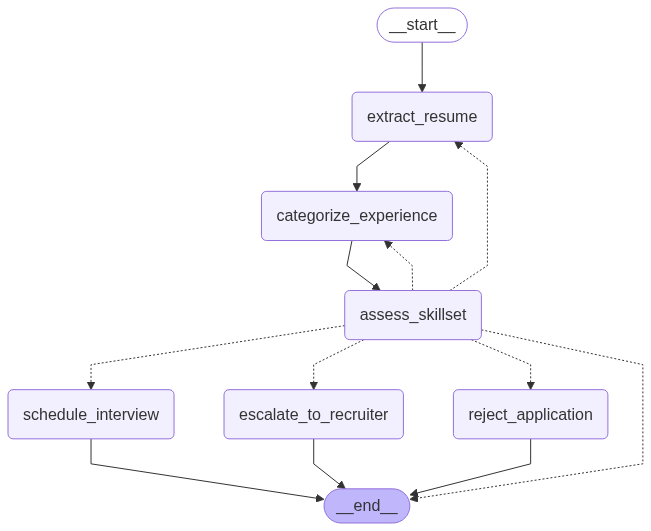

In [41]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [42]:
def run_candidate_screening(pdf_path: str, candidate_email: str, job_description: str = JOB_DESCRIPTION):
    """Run the candidate screening process with a PDF resume and send email notification."""
    results = app.invoke({
        "application": pdf_path,
        "job_description": job_description,
        "candidate_email": candidate_email
    })
    return {
        "resume_path": pdf_path,
        "candidate_email": candidate_email,
        "extracted_resume": results["extracted_resume"],
        "experience_level": results["experience_level"],
        "skill_match": results["skill_match"],
        "response": results["response"]
    }

In [43]:
if __name__ == "__main__":

    pdf_path = "Personal_Resume.pdf"
    candidate_email = "hariprasaadh2005@gmail.com"
    try:
        results = run_candidate_screening(pdf_path, candidate_email)
        print("\nScreening Results:")
        print(f"Resume: {results['resume_path']}")
        print(f"Candidate Email: {results['candidate_email']}")
        print(f"Experience Level: {results['experience_level']}")
        print(f"Skill Match: {results['skill_match']}")
        print(f"Response: {results['response']}")
    except Exception as e:
        print(f"Error processing resume: {str(e)}")


Categorizing experience level of candidate

Assessing candidate skills

Escalating to a recruiter
Email sent to hariprasaadh2005@gmail.com

Screening Results:
Resume: Personal_Resume.pdf
Candidate Email: hariprasaadh2005@gmail.com
Experience Level: Entry Level
Skill Match: Partial Match
Response: Candidate has been escalated to a recruiter for further review.
